In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *
import cv2
import torch
import torch.optim

from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

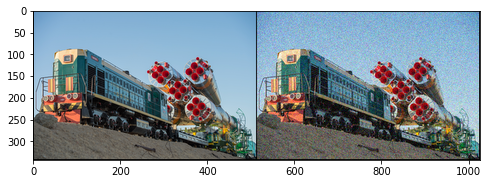

In [2]:
# deJPEG 
# fname = 'data/denoising/snail.jpg'

## denoising
fname = '/root/autodl-tmp/INCODE-main/data/image/0720.png'
im = plt.imread(fname).astype(np.float32)*255
im = cv2.resize(im, None, fx=1/4, fy=1/4, interpolation=cv2.INTER_AREA)
# img_pil = crop_image(get_image(fname, imsize)[0], d=32)
img_pil =im
img_np = pil_to_np(img_pil)

img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

if PLOT:
    plot_image_grid([img_np, img_noisy_np], 4, 6);

In [3]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./25. # set to 1./20. for sigma=50
LR = 0.001

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

num_iter = 5000
input_depth = 64
figsize = 4 


net = get_net(input_depth, 'skip', pad,
                skip_n33d=192, 
                skip_n33u=192, 
                skip_n11=4, 
                num_scales=5,
                upsample_mode='bilinear').type(dtype)
net_input = get_noise(input_depth, INPUT, (img_pil.shape[0], img_pil.shape[1]), var=1./0.1).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)
img_gt_torch = np_to_torch(img_np).type(dtype)


Number of params: 4991783


In [4]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
truth_psnr=[]
noise_psnr=[]
cumulative_times = []
start_time = time.time()

def closure():
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
        print(1)
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    # total_loss = mse(out, img_noisy_torch)
    total_loss = mse(out, img_gt_torch)
    total_loss.backward()
        
    
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    truth_psnr.append(psrn_gt)
    noise_psnr.append(psrn_noisy)
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    
    current_total_time = time.time() - start_time
    cumulative_times.append(current_total_time)
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

Starting optimization with ADAM


  0%|          | 0/5000 [00:00<?, ?it/s]

1


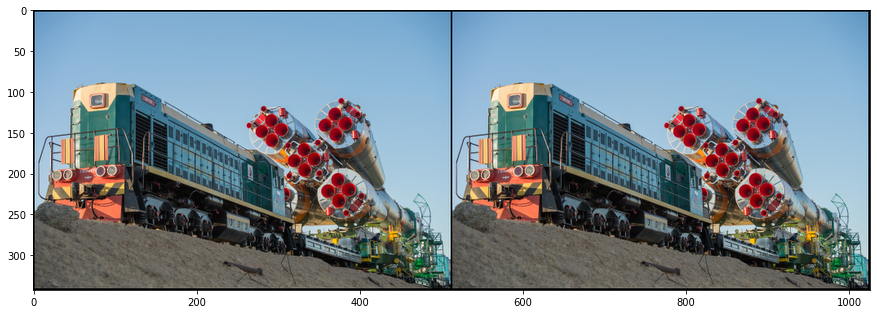

In [5]:
out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


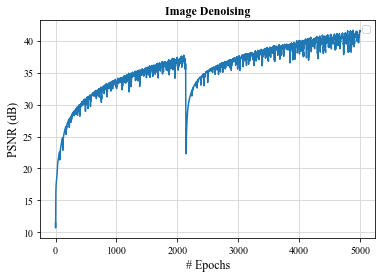

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Max PSNR: 41.62803792496254


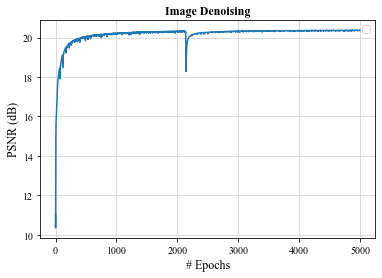

In [6]:
font = {'font': 'Times New Roman', 'size': 12}

plt.figure()
axfont = {'family' : 'Times New Roman', 'weight' : 'regular', 'size'   : 10}
plt.rc('font', **axfont)

plt.plot(np.arange(len(truth_psnr[:-1])),   truth_psnr[:-1])
plt.xlabel('# Epochs', fontdict=font)
plt.ylabel('PSNR (dB)', fontdict=font)
plt.title('Image Denoising', fontdict={'family': 'Times New Roman', 'size': 12, 'weight': 'bold'})
plt.legend()
plt.grid(True, color='lightgray')

plt.show()
print('Max PSNR:',np.array(truth_psnr[:-1]).max())
plt.figure()
axfont = {'family' : 'Times New Roman', 'weight' : 'regular', 'size'   : 10}
plt.rc('font', **axfont)

plt.plot(np.arange(len(noise_psnr[:-1])),   noise_psnr[:-1])
plt.xlabel('# Epochs', fontdict=font)
plt.ylabel('PSNR (dB)', fontdict=font)
plt.title('Image Denoising', fontdict={'family': 'Times New Roman', 'size': 12, 'weight': 'bold'})
plt.legend()
plt.grid(True, color='lightgray')

plt.show()

In [7]:
import torch
import lpips
lpips_vgg_model = lpips.LPIPS(net="vgg")
lpips_alex_model = lpips.LPIPS(net="alex")

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /root/miniconda3/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /root/miniconda3/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [8]:
img_np=torch.tensor(img_np).clone().detach()
out_np=torch.tensor(out_np).clone().detach()
vgg_distance = lpips_vgg_model(img_np, out_np)
alex_distance = lpips_alex_model(img_np, out_np)
print("VGG: LPIPS distance:", vgg_distance.item())
print("ALEX: LPIPS distance:", alex_distance.item())
print('----------------------------------\n\n')


VGG: LPIPS distance: 0.006520720664411783
ALEX: LPIPS distance: 0.0009887355845421553
----------------------------------




In [9]:
from pytorch_msssim import ssim
SSIM =ssim(torch.unsqueeze(img_np,dim=0),torch.unsqueeze(out_np,dim=0), data_range=1, size_average=False)
print(SSIM)

tensor([0.9915])
